# Computing Optimal Enhancement Order for Hayato's 6th Job
## How to Use This
#### There are three forms corresponding to FD values of IED/Boss, the BA proportions of the six boosted skills in 6th job, and the current levels of your six skills. Fill them out or leave them default. When done, click `Runtime` --> `Run All`. Your upgrade order will be output at the bottom.

In [613]:
#@title Hayato 6th job Skill Strength Increases (Enhancement [5th job], Mastery [4th job], and Origin Skill Cores)
import numpy as np
import copy
import math

# more info: https://www.reddit.com/r/Maplestory/comments/17htmz3/new_age_patch_breakdown_part_2_the_6th_job/
'''
5th job enhancement strength array 
levels 1-30, from lvl 1-9:11-19% fd, lvl 10-19: 25-34% fd, 
lvl 20-29: 40-49% fd, lvl30 = 60% fd
additive FD, level 1 starts at 1.11 multiplier, then 1.12, 1.13, ..., 1.60
'''
ENH_5TH = np.array([
         0.11, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, # level 1-9 = 19fd
         0.06, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, # level 10 - 19 = 34fd
         0.06, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, # level 20 - 29 = 49fd
         0.11 ]) # level 30 = 60fd

'''
origin enhancement strength array
per level increase: first slash: 30%, 3 slices: 20% each, last slash: 80%
level 1:  (1130 * 8 * 10 + 920  * 10 * 15 + 2480 * 15 * 10) = 600400% damage
level 2:  (1160 * 8 * 10 + 940  * 10 * 15 + 2560 * 15 * 10) = 17400% damage per level
level 30: (2000 * 8 * 10 + 1500 * 10 * 15 + 4800 * 15 * 10) = 1105000% damage = 84% fd
origin skill has additional bonuses at lvl 10, 20, 30
10: 20 ied, 20: bd, 30: 30 ied, 30 bd -- calculated as placeholder FD
this array is applied multiplicatively, not additively, unlike ENH_5TH
'''
ENH_ORI = np.array([(600400 + i*17400)/(600400 + (i-1)*17400) for i in range (1, 31)])
# ori_dict = {10: 1.01, 20: 1.025, 30: 1.04} # spitball fd values, applied multiplicatively
# for index, value in ori_dict.items():
#     ENH_ORI[index-1] = ENH_ORI[index-1] * value

'''
4th job mastery enhancement strength array
level 0->1:   354 -> 366%
level 1->2:   366 -> 372% = 6% damage per level
level 29->30: 540 -> 546% = 50% fd total
this array is applied multiplicatively, not additively
'''
ENH_4TH = np.array([((360 + i*6)/(360 + (i-1)*6)) for i in range (1, 31)])
ENH_4TH[0] = 1.0547 # 366/347 (lvl21 rbf) = 1.0547



### Origin Skill Boosts at Level 10, 20 and 30
- lv10: 20 IED  
- lv20: 20 Boss 
- lv30: 30 IED, 30 Boss 

In [614]:
#@title Personal FD for lv10,20,30 boosts of origin skill (read above)

lv10 = 1.01 #@param {allow-input: true, type:"number"}
lv20 = 1.02 #@param {allow-input: true, type:"number"}
lv30 = 1.04 #@param {allow-input: true, type:"number"}

ori_dict = {10: lv10, 20: lv20, 30:lv30}
for index, value in ori_dict.items():
    ENH_ORI[index-1] = ENH_ORI[index-1] * value


In [615]:
#@title Multiplicative FD per level of HEXA RBF boost 
ENH_4TH.round(4)

array([1.0547, 1.0164, 1.0161, 1.0159, 1.0156, 1.0154, 1.0152, 1.0149,
       1.0147, 1.0145, 1.0143, 1.0141, 1.0139, 1.0137, 1.0135, 1.0133,
       1.0132, 1.013 , 1.0128, 1.0127, 1.0125, 1.0123, 1.0122, 1.012 ,
       1.0119, 1.0118, 1.0116, 1.0115, 1.0114, 1.0112])

In [616]:
#@title Multiplicative FD per level of Origin Skill boost
ENH_ORI.round(4)

array([1.029 , 1.0282, 1.0274, 1.0267, 1.026 , 1.0253, 1.0247, 1.0241,
       1.0235, 1.0332, 1.0225, 1.022 , 1.0215, 1.0211, 1.0206, 1.0202,
       1.0198, 1.0194, 1.019 , 1.0391, 1.0183, 1.018 , 1.0177, 1.0174,
       1.0171, 1.0168, 1.0165, 1.0163, 1.016 , 1.0564])

In [617]:
#@title Enhancement cost arrays
# level 2-30
ORIGIN_COST      = np.array([(1, 30),  (1, 35),  (1, 40),  (2, 45),   (2, 50),
                             (2, 55),  (3, 60),  (3, 65),  (10, 200), (3, 80),
                             (3, 90),  (4, 100), (4, 110), (4, 120),  (4, 130),
                             (4, 140), (4, 150), (5, 160), (15, 350), (5, 170),  
                             (5, 180), (5, 190), (5, 200), (5, 210),  (6, 220),  
                             (6, 230), (6, 240), (7, 250), (20, 500)])
# level 1-30
MASTER_COST     = np.array([(3, 50),  (1, 15),  (1, 18),  (1, 20),  (1, 23),
                             (1, 25),  (2, 28),  (2, 30),  (2, 33),  (5, 100),
                             (2, 40),  (2, 45),  (2, 50),  (2, 55),  (2, 60),
                             (2, 65),  (2, 70),  (2, 75),  (3, 80),  (8, 175),
                             (3, 85),  (3, 90),  (3, 95),  (3, 100), (3, 105),
                             (3, 110), (3, 115), (3, 120), (4, 125), (10, 250)])
# level 1-30
ENHANCEMENT_COST = np.array([(4, 75),  (1, 23),  (1, 27),  (1, 30),  (2, 34),
                             (2, 38),  (2, 42),  (3, 45),  (3, 49),  (8, 150),
                             (3, 60),  (3, 68),  (3, 75),  (3, 83),  (3, 90),
                             (3, 98),  (3, 105), (4, 113), (4, 120), (12, 263),
                             (4, 128), (4, 135), (4, 143), (4, 150), (4, 158),
                             (5, 165), (5, 173), (6, 180), (6, 188), (15, 375)])

In [618]:
#@title Hardcoded Full Rot and Burst BA proportions in percentages
# taken from Labels' BA
# assuming unleveled enhancement cores (lvl 0, no fd)
ba_prop    = {"zankou" :0.110,
              "slice"  :0.079,
              "jamal"  :0.067,
              "pb"     :0.064,
              "jinqd"  :0.084, # origin skill
              "rbf"    :0.336}

burst_prop = {"zankou" :0.139,
              "slice"  :0.076,
              "jamal"  :0.106,
              "pb"     :0.073,
              "jinqd"  :0.281, # origin skill
              "rbf"    :0.137}

# dictionary to keep track of current upgrade level of each skill
# key: skill name, value: level (corresponds to index of ENH_5TH)
skills = {"zankou": 0, 
          "slice":  0, 
          "jamal":  0, 
          "pb":     0, 
          "jinqd":  1, # idk how origin skill damage increase works
          "rbf":    0}

In [619]:
#@title Your Personal BA Skill Proportions { vertical-output: true }
p_zankou  = 0.110 #@param {allow-input: true, type:"number"}
p_slice   = 0.079 #@param {allow-input: true, type:"number"}
p_susanoo = 0.067 #@param {allow-input: true, type:"number"}
p_pb      = 0.064 #@param {allow-input: true, type:"number"}
p_jinqd   = 0.084 #@param {allow-input: true, type:"number"}
p_rbf     = 0.336 #@param {allow-input: true, type:"number"}

BA_PROP    = {"zankou" :p_zankou,
              "slice"  :p_slice,
              "jamal"  :p_susanoo,
              "pb"     :p_pb,
              "jinqd"  :p_jinqd, # origin skill
              "rbf"    :p_rbf}

In [620]:
#@title Your Current HEXA Skill Levels { vertical-output: true }
l_zankou  = 0 #@param {allow-input: true, type:"integer"}
l_slice   = 0 #@param {allow-input: true, type:"integer"}
l_susanoo = 0 #@param {allow-input: true, type:"integer"}
l_pb      = 0 #@param {allow-input: true, type:"integer"}
l_jinqd   = 1 #@param {allow-input: true, type:"integer"}
l_rbf     = 0 #@param {allow-input: true, type:"integer"}

skills = {"zankou": l_zankou, 
          "slice":  l_slice, 
          "jamal":  l_susanoo, 
          "pb":     l_pb, 
          "jinqd":  l_jinqd, # idk how origin skill damage increase works
          "rbf":    l_rbf}

## "Greedy" Search for Upgrade Order
### Computation Methodology
There are 6 skills we can boost currently: `Rai Blade Flash` (Mastery Core [4th Job]), `Jin Quick Draw` (Origin Core [6th Job]), and `Instant Slice, Zankou, Phantom Blade, and Susano-o` (Enhancement Core [5th Job]).

In the BA's provided by Labels, these 6 skills each make up some % (let's call them `proportions`) of the BA (total 100%, or `1.0`). In the first step, the algorithm picks RBF to upgrade first. Why? RBF unboosted makes up `0.336` (33.6%) of a full rotation BA. Leveling its Mastery Core from 0-->1 is a 5.47% fd increase (366% damage level 1, 347% damage unboosted) and provides an absolute `0.018` (1.8%) increase to the BA. Its upgrade cost is 3 Sol Erda and 50 fragments, which I calculate as (`3 * energy + 1 * fragments`). Feel free to give me a better cost ratio. The strength_gain:cost ratio (`0.018/350`) is the highest of the 6 skills, so it is picked. 

As a result, RBF's new proportion in a BA would be `0.354` out of `1.018` (`1.0 + 0.018`). Then, in order to normalize the `proportions` to be percentages, we recalculate the initial `proportions` to be out of this new `1.018` value (let's call it `total_strength`). 

This process iterates until all skills have been fully upgraded.

NOTE: All the hardcoded proportions are subject to change when 6th job lands and GMS people do BAs. This is a greedy algorithm that only looks at the immediate damage gain and immediate cost. We can tune these costs and heuristics. This is especially important because the amortized FD gain spikes as you approach levels 10, 20, and 30.

In [621]:
#@title Cost, FD Gain, and Heuristic Functions
def cost_fn(skill, level, desired_level, mean="geometric"):
    '''
    returns the cost of upgrading a skill to a certain level
    '''
    energy, fragments = 0, 0
    if skill == "jinqd":
        energy, fragments = ORIGIN_COST[level-1:desired_level-1].sum(axis=0)
    elif skill == "rbf":
        energy, fragments = MASTER_COST[level:desired_level].sum(axis=0)
    else:
        energy, fragments = ENHANCEMENT_COST[level:desired_level].sum(axis=0)
    return (100*energy) + fragments

def fd_gain(skill, level, desired_level):
    '''
    returns the strength proportions of skill at its current level and at a certain upgraded level
    '''
    orig_prop = BA_PROP[skill] # original proportion
    cprop, nprop = 0, 0
    if skill == "jinqd":
        cprop = ENH_ORI[:level].prod() * orig_prop
        nprop = ENH_ORI[:desired_level].prod() * orig_prop
    elif skill == "rbf":
        cprop = ENH_4TH[:level].prod() * orig_prop
        nprop = ENH_4TH[:desired_level].prod() * orig_prop
    else:
        cprop = (1 + ENH_5TH[:level].sum()) * orig_prop
        nprop = (1 + ENH_5TH[:desired_level].sum()) * orig_prop
    strength_increase = nprop - cprop
    return strength_increase, cprop, nprop

def ratio_fn(fd, cost, mean="arithmetic"):
    return (fd*1000) / cost

def round10(x):
    # return math.ceil(x / 10.0) * 10
    return int(round(x + 5.1, -1))

# TODO: lookahead fn to see how much fd is coming up. stops when next level provides worse per level efficiency than prior level
# strategy is as described here: https://github.com/acyr0/phantom_hexacore_sim/blob/dd268c4d665bef1c1ff27188029b2105fa8804b4/src/main.rs#L90
def lookahead_fn(skill, level, strategy="default"):
    choices = []
    if (level + 1) % 10 != 0:
        rlevel = round10(level) # round to nearest 10
        strength_gain = fd_gain(skill, level, rlevel)[0]
        rratio = ratio_fn(strength_gain, cost_fn(skill, level, rlevel))
        choices.append((rlevel, rratio, strength_gain))
    elif (level + 1) % 10 == 0:
        best_ratio = 0
        curr_ratio = 0
        best_strength_gain = 0
        nlevel = level + 2 # lookahead starting from 1 past level 0/10/20
        while (curr_ratio >= best_ratio) and (nlevel - 1 < len(ENH_5TH)):
            strength_gain = fd_gain(skill, level, nlevel)[0]
            curr_ratio = ratio_fn(strength_gain, cost_fn(skill, level, nlevel))
            if curr_ratio > best_ratio: 
                best_ratio = curr_ratio
                best_strength_gain = strength_gain
            nlevel += 1
        choices.append((nlevel - 1, best_ratio, best_strength_gain))

    return choices


In [622]:
#@title Function to calculate overall strength, skipping discretized steps of greedy search
# basically a validation function
def calculate_strength(fd_multipliers, origin_multipliers):
    temp_fd = copy.deepcopy(ba_prop)
    for skill_name, pct in ba_prop.items():
        if skill_name == "jinqd":
            temp_fd[skill_name] *= 2.01
        elif skill_name == "rbf":
            temp_fd[skill_name] *= 1.54
        else:
            temp_fd[skill_name] *= 1.6
    # sum of all fd * proportion of each skill
    increase = (np.array(list(temp_fd.values())) - np.array(list(ba_prop.values()))).sum()
    return  (1 + increase / 1)

In [623]:
#@title Main Loop { vertical-output: true }
verbose_order = []
order = [] # order of upgrades
total_strength_gain = 1.0
temp_prop   = copy.deepcopy(BA_PROP)
temp_skills = copy.deepcopy(skills)
upgrade_order = []
# Brute force search
# for iteration in range(180):
iteration = 0
while (np.array(list(temp_skills.values())).sum()) < 180: # until skill levels are maxed
    print(f"Upgrade: {iteration} total_strength_gain: {total_strength_gain}")
    max_strength_increase = 0
    max_strength_increase_ratio = 0
    max_strength_level = 0
    selected_skill = None
    new_prop = 0

    # Iterate through each skill
    for skill_name, level in temp_skills.items():
        # Forecast one level ahead for each skill
        level = int(level)
        next_level = int(level + 1)
        # Check if the skill has reached the maximum level
        if next_level > len(ENH_5TH):
            continue

        # Calculate proportional increase in strength
        # strength_increase = (total_strength_gain + (ngain * orig_prop) - prop) / (total_strength_gain)
        cost = 0
        cprop = 0 # current contribution of total damage (absolute value, not proportion)
        nprop = 0 # new contribution of total damage
        cost = cost_fn(skill_name, level, next_level)
        strength_increase, cprop, nprop = fd_gain(skill_name, level, next_level)

        direct_strength_cost_ratio = ratio_fn(strength_increase, cost)
        choices = lookahead_fn(skill_name, level)
        choices.append((next_level, direct_strength_cost_ratio, strength_increase))
        choices = np.nan_to_num(np.array(choices))
        desired_level, strength_cost_ratio, strength_increase = choices[np.argmax(choices[:,1])]
        desired_level = int(desired_level)
        print(f"skill: {skill_name:>6} ({level} -> {desired_level}), nprop: {np.round(nprop, 3):>5}, cprop: {np.round(cprop,3):>5}, strength_increase: {np.round(strength_increase,4):>6}, cost: {cost:>4}, ratio: {np.round(strength_cost_ratio, 4)}")
        
        # Check if this is the maximum increase so far
        # if strength_increase > max_strength_increase:
        if strength_cost_ratio > max_strength_increase_ratio:
            max_strength_increase = strength_increase
            max_strength_increase_ratio = strength_cost_ratio
            max_strength_level = desired_level
            selected_skill = skill_name
            new_prop = nprop
            # recalculating total strength gain

    # Apply the selected enhancement
    if selected_skill is not None:
        # temp_skills[selected_skill] += 1 # increase level by 1
        upgrade_order.append((selected_skill, max_strength_level))
        temp_skills[selected_skill] = max_strength_level
        # Increment total strength gain and update the skill damage proportions
        prev_total_strength = total_strength_gain
        total_strength_gain += max_strength_increase
        true_fd_gain = np.round(total_strength_gain/prev_total_strength, 4)
        true_fd_gain_pct = f"{true_fd_gain - 1.000:0.3%}"
        for skill_name, prop in temp_prop.items():
            temp_prop[skill_name] = prop/total_strength_gain
        temp_prop[selected_skill] = new_prop/total_strength_gain
        update_str = f"Upgrade #: {iteration + 1:>3}, Skill: {selected_skill:>6}, New Level: {temp_skills[selected_skill]:>2}, True FD Gained: {true_fd_gain_pct:>5}, max_strength_increase: {round(max_strength_increase, 4):>5}, max_strength_increase_ratio: {round(max_strength_increase_ratio, 4)}"
        print(update_str)
        order.append(update_str)

    iteration +=1
# After the loop, you can print the final results
final_strength = calculate_strength(dict, ENH_ORI)
print("Final Strength (validation if starting from 0):", final_strength)
print(f"temp_prop: {temp_prop}")

Upgrade: 0 total_strength_gain: 1.0
skill: zankou (0 -> 1), nprop: 0.122, cprop:  0.11, strength_increase: 0.0121, cost:  475, ratio: 0.0255
skill:  slice (0 -> 1), nprop: 0.088, cprop: 0.079, strength_increase: 0.0087, cost:  475, ratio: 0.0183
skill:  jamal (0 -> 1), nprop: 0.074, cprop: 0.067, strength_increase: 0.0074, cost:  475, ratio: 0.0155
skill:     pb (0 -> 1), nprop: 0.071, cprop: 0.064, strength_increase:  0.007, cost:  475, ratio: 0.0148
skill:  jinqd (1 -> 2), nprop: 0.089, cprop: 0.086, strength_increase: 0.0024, cost:  130, ratio: 0.0187
skill:    rbf (0 -> 1), nprop: 0.354, cprop: 0.336, strength_increase: 0.0184, cost:  350, ratio: 0.0525
Upgrade #:   1, Skill:    rbf, New Level:  1, True FD Gained: 1.840%, max_strength_increase: 0.0184, max_strength_increase_ratio: 0.0525
Upgrade: 1 total_strength_gain: 1.0183792
skill: zankou (0 -> 1), nprop: 0.122, cprop:  0.11, strength_increase: 0.0121, cost:  475, ratio: 0.0255
skill:  slice (0 -> 1), nprop: 0.088, cprop: 0.079

In [624]:
#@title Simplified Upgrade Order (Look at This)
order

['Upgrade #:   1, Skill:    rbf, New Level:  1, True FD Gained: 1.840%, max_strength_increase: 0.0184, max_strength_increase_ratio: 0.0525',
 'Upgrade #:   2, Skill:    rbf, New Level:  2, True FD Gained: 0.570%, max_strength_increase: 0.0058, max_strength_increase_ratio: 0.0505',
 'Upgrade #:   3, Skill:    rbf, New Level:  3, True FD Gained: 0.570%, max_strength_increase: 0.0058, max_strength_increase_ratio: 0.0492',
 'Upgrade #:   4, Skill:    rbf, New Level:  4, True FD Gained: 0.560%, max_strength_increase: 0.0058, max_strength_increase_ratio: 0.0484',
 'Upgrade #:   5, Skill:    rbf, New Level:  5, True FD Gained: 0.560%, max_strength_increase: 0.0058, max_strength_increase_ratio: 0.0472',
 'Upgrade #:   6, Skill:    rbf, New Level:  6, True FD Gained: 0.560%, max_strength_increase: 0.0058, max_strength_increase_ratio: 0.0465',
 'Upgrade #:   7, Skill:    rbf, New Level:  7, True FD Gained: 0.550%, max_strength_increase: 0.0058, max_strength_increase_ratio: 0.0255',
 'Upgrade #: 

In [625]:
upgrade_order

[('rbf', 1),
 ('rbf', 2),
 ('rbf', 3),
 ('rbf', 4),
 ('rbf', 5),
 ('rbf', 6),
 ('rbf', 7),
 ('zankou', 1),
 ('rbf', 8),
 ('rbf', 9),
 ('rbf', 19),
 ('jinqd', 2),
 ('slice', 1),
 ('jinqd', 3),
 ('jinqd', 4),
 ('jamal', 1),
 ('pb', 1),
 ('rbf', 29),
 ('jinqd', 5),
 ('jinqd', 6),
 ('jinqd', 7),
 ('zankou', 2),
 ('zankou', 3),
 ('zankou', 4),
 ('jinqd', 8),
 ('jinqd', 9),
 ('slice', 2),
 ('slice', 3),
 ('slice', 4),
 ('jamal', 2),
 ('jamal', 3),
 ('pb', 2),
 ('jamal', 4),
 ('zankou', 10),
 ('pb', 3),
 ('pb', 4),
 ('rbf', 30),
 ('jinqd', 18),
 ('jinqd', 19),
 ('slice', 10),
 ('jinqd', 26),
 ('jinqd', 30),
 ('zankou', 20),
 ('jamal', 10),
 ('pb', 10),
 ('zankou', 30),
 ('slice', 20),
 ('slice', 30),
 ('jamal', 20),
 ('pb', 20),
 ('jamal', 30),
 ('pb', 30)]

## Scraps

In [640]:
'rbf' == upgrade_order[0][0]

True

In [645]:
trimmed_upgrade_order = []
prev_entry = ('rbf', 1)

for entry in upgrade_order:
    # print(entry[0])
    if entry[0] == prev_entry[0]:
        prev_entry = entry
        continue
    else:
        trimmed_upgrade_order.append((prev_entry))
    prev_entry = entry
trimmed_upgrade_order


[('rbf', 7),
 ('zankou', 1),
 ('rbf', 19),
 ('jinqd', 2),
 ('slice', 1),
 ('jinqd', 4),
 ('jamal', 1),
 ('pb', 1),
 ('rbf', 29),
 ('jinqd', 7),
 ('zankou', 4),
 ('jinqd', 9),
 ('slice', 4),
 ('jamal', 3),
 ('pb', 2),
 ('jamal', 4),
 ('zankou', 10),
 ('pb', 4),
 ('rbf', 30),
 ('jinqd', 19),
 ('slice', 10),
 ('jinqd', 30),
 ('zankou', 20),
 ('jamal', 10),
 ('pb', 10),
 ('zankou', 30),
 ('slice', 30),
 ('jamal', 20),
 ('pb', 20),
 ('jamal', 30)]

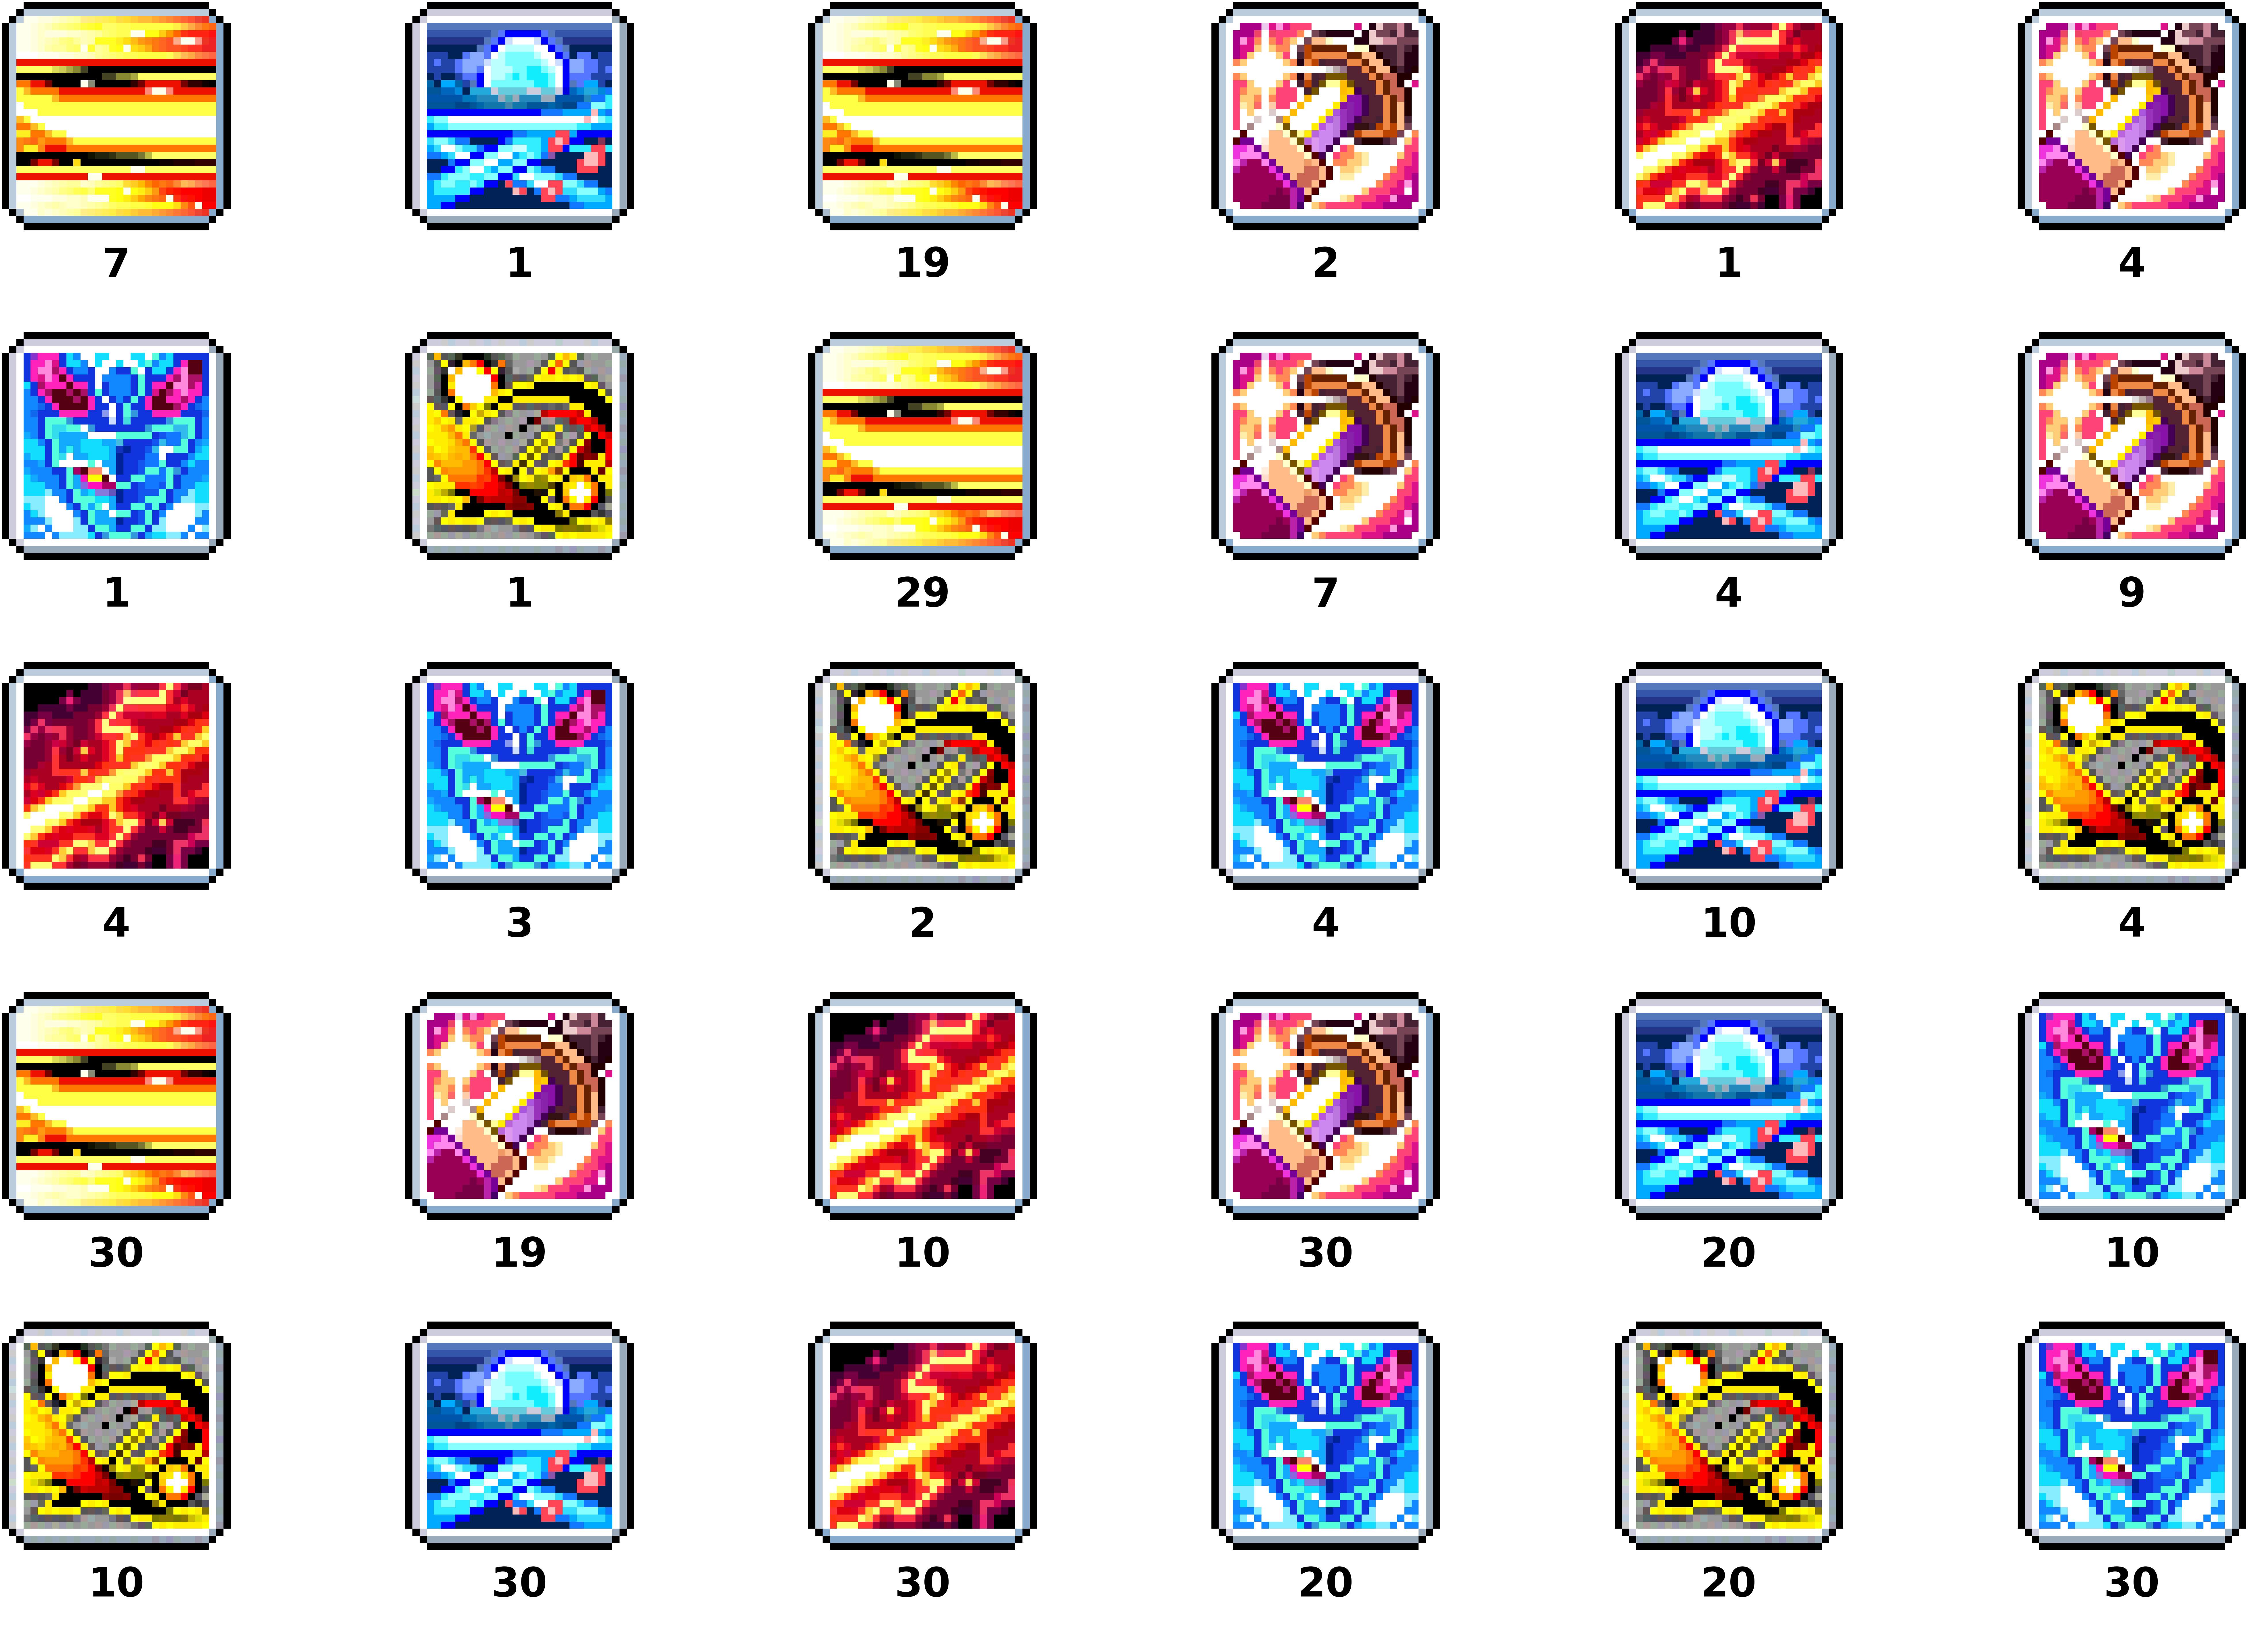

In [659]:
import matplotlib.pyplot as plt
import numpy as np

# Define the skill names and their corresponding images
skill_images = {
    "rbf":    "icons/rbf.webp",
    "zankou": "icons/zankou.webp",
    "jinqd":  "icons/jinqd.webp",
    "slice":  "icons/slice.webp",
    "jamal":  "icons/jamal.webp",
    "pb":     "icons/pb.webp",
}

# Function to plot the skill upgrades
def plot_skill_upgrades(skill_order):
    fig, axes = plt.subplots(5, 6, figsize=(120, 80))
    axes = axes.flatten()

    for i, (skill_name, new_level) in enumerate(skill_order):
        # Load skill image
        image_path = skill_images.get(skill_name)
        img = plt.imread(image_path)

        # Plot the skill image
        axes[i].imshow(img)
        axes[i].axis("off")

        # Add text below the skill image
        text = f"{new_level}\n"
        axes[i].text(0.5, -0.4, text, size=160, ha="center", transform=axes[i].transAxes)

    plt.tight_layout()
    plt.show()

# Plot the skill upgrades
plot_skill_upgrades(trimmed_upgrade_order)
